In [2]:
# Impor pustaka yang dibutuhkan
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import glob

In [3]:
# Setel seed acak untuk reproduktibilitas
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [4]:
# Tentukan jalur ke data dan ambil semua file CSV
data_path = "C:/D/projects/BPP PROJECT/bpp-prediction/backend/datasets/"
csv_files = glob.glob(data_path + "*.csv")

In [5]:
# Fungsi untuk memuat dan membersihkan data (menangani nilai yang hilang)
def load_and_clean_data(file_path):
    df = pd.read_csv(file_path, delimiter=';')
    df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d/%m/%Y')
    df.set_index('Tanggal', inplace=True)
    
    # Menangani data yang hilang
    df = df.fillna(method='ffill')  # Menggunakan pengisian maju untuk menangani data yang hilang
    
    return df

In [6]:
# Memuat semua dataset
datasets = {file.split("\\")[-1]: load_and_clean_data(file) for file in csv_files}


C:\Users\user\AppData\Local\Temp\ipykernel_24768\2808223563.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Menggunakan pengisian maju untuk menangani data yang hilang
C:\Users\user\AppData\Local\Temp\ipykernel_24768\2808223563.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Menggunakan pengisian maju untuk menangani data yang hilang
C:\Users\user\AppData\Local\Temp\ipykernel_24768\2808223563.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')  # Menggunakan pengisian maju untuk menangani data yang hilang
C:\Users\user\AppData\Local\Temp\ipykernel_24768\2808223563.py:8: FutureWarning: DataFrame.fillna with 'me

In [7]:
# Menampilkan informasi dataset
for name, df in datasets.items():
    print(f"\nDataset: {name}")
    display(df.head())
# Kamus untuk menyimpan scaler untuk setiap dataset
scalers = {}


Dataset: bawang_merah.csv


,Harga
Tanggal,
2021-04-01,27970
2021-04-02,27730
2021-04-03,27770
2021-04-04,27730
2021-04-05,27530



Dataset: bawang_putih.csv


,Harga
Tanggal,
2021-04-01,24220
2021-04-02,24090
2021-04-03,24080
2021-04-04,24280
2021-04-05,24120



Dataset: beras_medium.csv


,Harga
Tanggal,
2021-04-01,10180
2021-04-02,10110
2021-04-03,10180
2021-04-04,10140
2021-04-05,10090



Dataset: beras_premium.csv


,Harga
Tanggal,
2021-04-01,11380
2021-04-02,11350
2021-04-03,11420
2021-04-04,11380
2021-04-05,11330



Dataset: cabai_merah_keriting.csv


,Harga
Tanggal,
2021-04-01,46780
2021-04-02,47270
2021-04-03,48050
2021-04-04,47180
2021-04-05,47930



Dataset: cabai_rawit_merah.csv


,Harga
Tanggal,
2021-04-01,66080
2021-04-02,63860
2021-04-03,63800
2021-04-04,63760
2021-04-05,66590



Dataset: daging_ayam_ras.csv


,Harga
Tanggal,
2021-04-01,33980
2021-04-02,34000
2021-04-03,34210
2021-04-04,34310
2021-04-05,34960



Dataset: daging_sapi.csv


,Harga
Tanggal,
2021-04-01,109630
2021-04-02,109870
2021-04-03,109860
2021-04-04,110070
2021-04-05,109670



Dataset: gula_pasir.csv


,Harga
Tanggal,
2021-04-01,12200
2021-04-02,12180
2021-04-03,12140
2021-04-04,12150
2021-04-05,12160



Dataset: kedelai.csv


,Harga
Tanggal,
2021-04-01,10260
2021-04-02,10280
2021-04-03,10280
2021-04-04,10190
2021-04-05,10260



Dataset: telur_ayam_ras.csv


,Harga
Tanggal,
2021-04-01,20910
2021-04-02,21200
2021-04-03,21000
2021-04-04,21180
2021-04-05,21400


In [8]:
# Fungsi untuk menormalkan data
def normalize_data(df, dataset_name):
    """Menormalkan data dan menyimpan scaler untuk digunakan nanti"""
    scalers[dataset_name] = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scalers[dataset_name].fit_transform(df[['Harga']].values)
    return df_scaled

In [9]:
# Menormalkan semua dataset
scaled_datasets = {}
for file, df in datasets.items():
    print(f"\nMenormalkan dataset: {file}")
    scaled_datasets[file] = normalize_data(df, file)
    
    # Menampilkan sampel nilai asli dan nilai terormalisasi
    print("Nilai asli:", df['Harga'].head().values)
    print("Nilai terormalisasi:", scaled_datasets[file][:5].flatten())



Menormalkan dataset: bawang_merah.csv
Nilai asli: [27970 27730 27770 27730 27530]
Nilai terormalisasi: [0.20358579 0.19855898 0.19939678 0.19855898 0.19436997]

Menormalkan dataset: bawang_putih.csv
Nilai asli: [24220 24090 24080 24280 24120]
Nilai terormalisasi: [0.30012163 0.29353335 0.29302656 0.30316238 0.29505372]

Menormalkan dataset: beras_medium.csv
Nilai asli: [10180 10110 10180 10140 10090]
Nilai terormalisasi: [0.23134891 0.21376539 0.23134891 0.22130118 0.20874152]

Menormalkan dataset: beras_premium.csv
Nilai asli: [11380 11350 11420 11380 11330]
Nilai terormalisasi: [0.18579235 0.18032787 0.19307832 0.18579235 0.17668488]

Menormalkan dataset: cabai_merah_keriting.csv
Nilai asli: [46780 47270 48050 47180 47930]
Nilai terormalisasi: [0.45205289 0.45887265 0.4697286  0.45762004 0.46805846]

Menormalkan dataset: cabai_rawit_merah.csv
Nilai asli: [66080 63860 63800 63760 66590]
Nilai terormalisasi: [0.62580259 0.59865227 0.59791848 0.59742928 0.63203982]

Menormalkan dataset

In [10]:
import joblib

# Simpan semua scaler ke dalam file
scaler_path = "C:/D/projects/BPP PROJECT/bpp-prediction/backend/scalers_50/"
os.makedirs(scaler_path, exist_ok=True)

for dataset_name, scaler in scalers.items():
    joblib.dump(scaler, f"{scaler_path}{dataset_name}_scaler.pkl")

print("Semua scaler telah disimpan.")


Semua scaler telah disimpan.


In [11]:
# Fungsi untuk membuat urutan data untuk LSTM
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [12]:
# Membuat urutan untuk setiap dataset
datasets_X_y = {}
for file, scaled_data in scaled_datasets.items():
    print(f"\nMembuat dataset untuk {file}")
    X, y = create_dataset(scaled_data)
    datasets_X_y[file] = (X, y)
    print(f"X shape: {X.shape}, y shape: {y.shape}")



Membuat dataset untuk bawang_merah.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk bawang_putih.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk beras_medium.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk beras_premium.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk cabai_merah_keriting.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk cabai_rawit_merah.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk daging_ayam_ras.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk daging_sapi.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk gula_pasir.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk kedelai.csv
X shape: (1279, 60), y shape: (1279,)

Membuat dataset untuk telur_ayam_ras.csv
X shape: (1279, 60), y shape: (1279,)


In [13]:
# Fungsi untuk membagi data
def split_data(X, y, train_size=0.8):
    train_len = int(len(X) * train_size)
    X_train, X_test = X[:train_len], X[train_len:]
    y_train, y_test = y[:train_len], y[train_len:]
    return X_train, X_test, y_train, y_test


In [14]:
# Membagi data untuk setiap dataset
split_datasets = {}
for file, (X, y) in datasets_X_y.items():
    print(f"\nMembagi data untuk {file}")
    X_train, X_test, y_train, y_test = split_data(X, y)
    split_datasets[file] = (X_train, X_test, y_train, y_test)
    print(f"Bentuk set pelatihan: {X_train.shape}")
    print(f"Bentuk set pengujian: {X_test.shape}")



Membagi data untuk bawang_merah.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk bawang_putih.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk beras_medium.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk beras_premium.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk cabai_merah_keriting.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk cabai_rawit_merah.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk daging_ayam_ras.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk daging_sapi.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk gula_pasir.csv
Bentuk set pelatihan: (1023, 60)
Bentuk set pengujian: (256, 60)

Membagi data untuk kedelai.csv
Bentuk set pelatihan: (1023, 60)
Ben

In [15]:
# Fungsi untuk membangun model LSTM
def build_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model



Melatih model untuk bawang_merah.csv


C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0318 - val_loss: 0.0013
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 8.2446e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0031 - val_loss: 7.1433e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023 - val_loss: 5.5889e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0021 - val_loss: 4.3833e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017 - val_loss: 3.9252e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0017 - val_loss: 3.6046e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0016 - val_loss: 3.4072e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 3.8938e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 3.4960e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0012 - val_loss: 2.6043e-04
Epoch 12/50
29/29 ━━━━━

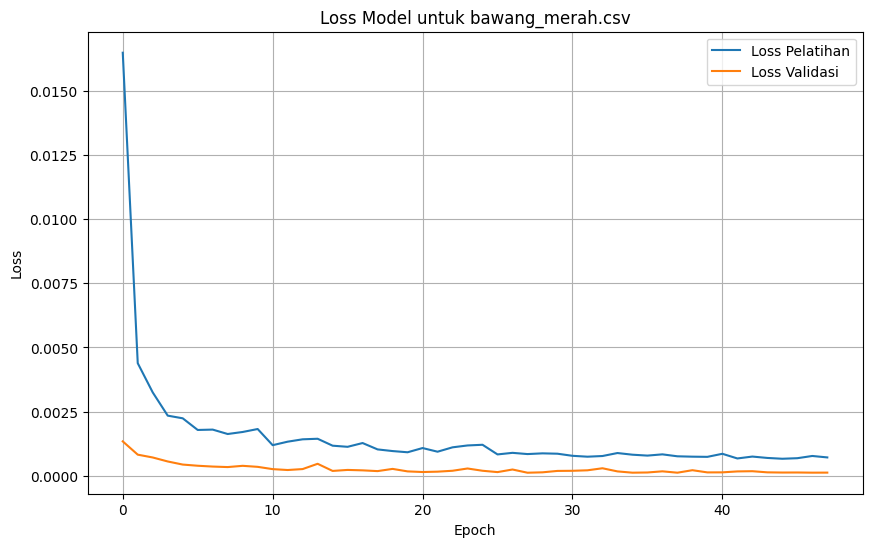


Melatih model untuk bawang_putih.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0830 - val_loss: 7.5301e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0036 - val_loss: 7.0300e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 6.8829e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0027 - val_loss: 8.1034e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 8.9249e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0028 - val_loss: 5.3013e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 5.5136e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0024 - val_loss: 8.6062e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0026 - val_loss: 9.3192e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0023 - val_lo

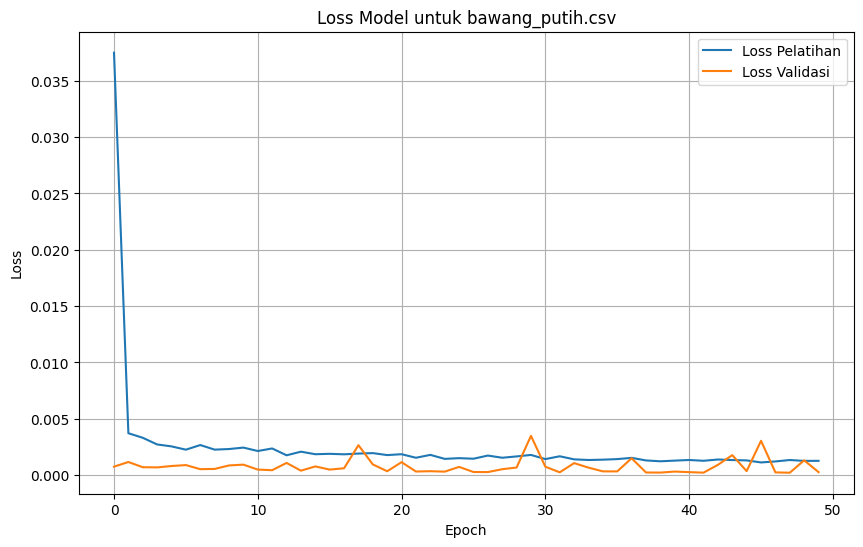


Melatih model untuk beras_medium.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0651 - val_loss: 0.0118
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0018 - val_loss: 0.0072
Epoch 12/50
29/29 ━━━━━━━

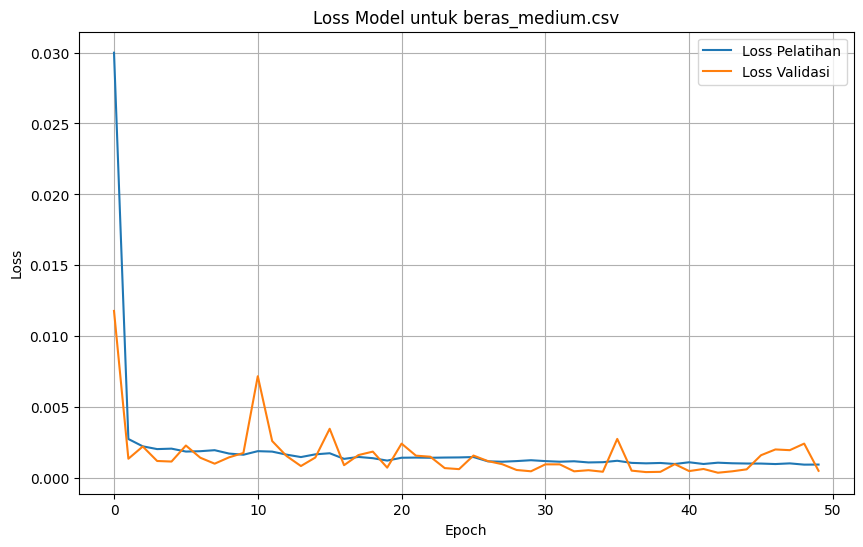


Melatih model untuk beras_premium.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0494 - val_loss: 0.0097
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 12/50
29/29 ━━━━━━

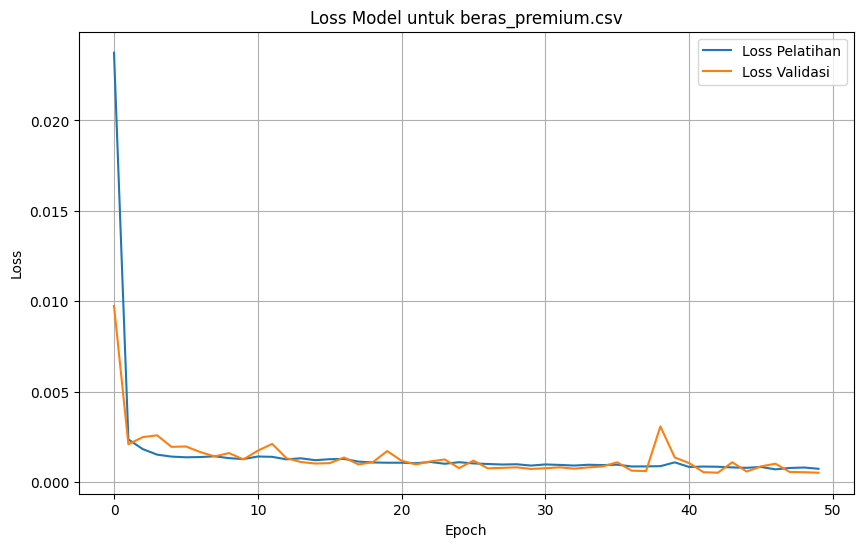


Melatih model untuk cabai_merah_keriting.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0258 - val_loss: 0.0105
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0041 - val_loss: 0.0063
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0035 - val_loss: 0.0060
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 12/50
29/29

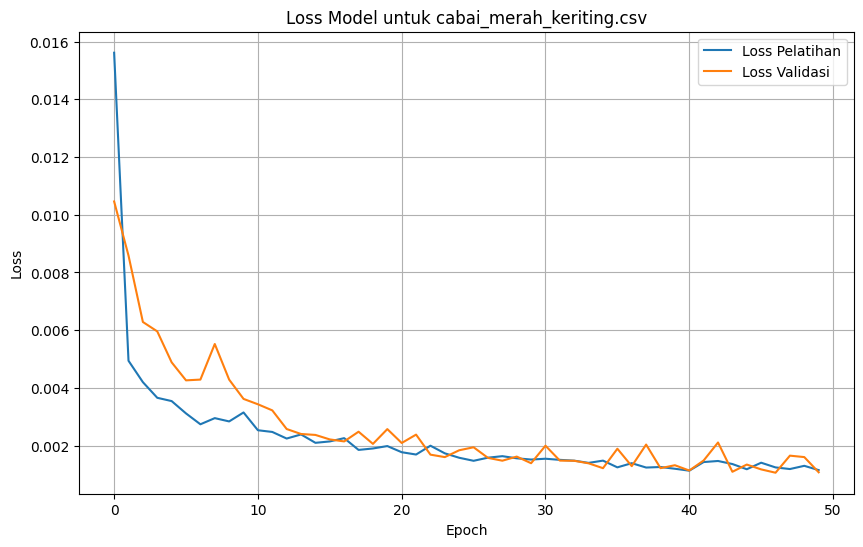


Melatih model untuk cabai_rawit_merah.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0261 - val_loss: 0.0084
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0096 - val_loss: 0.0052
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 0.0083
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0052 - val_loss: 0.0061
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 12/50
29/29 ━━

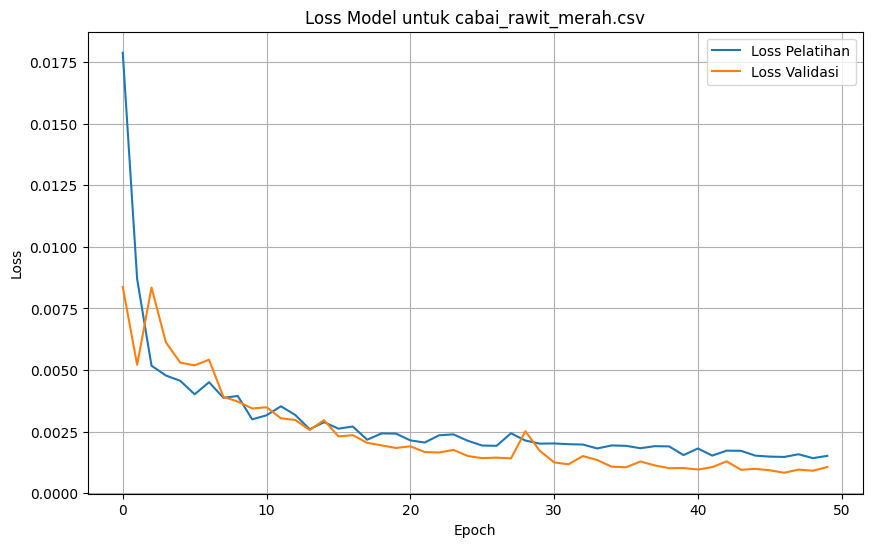


Melatih model untuk daging_ayam_ras.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.1149 - val_loss: 0.0075
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0120 - val_loss: 0.0045
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0102 - val_loss: 0.0034
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0079 - val_loss: 0.0032
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0059 - val_loss: 0.0024
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 12/50
29/29 ━━━━

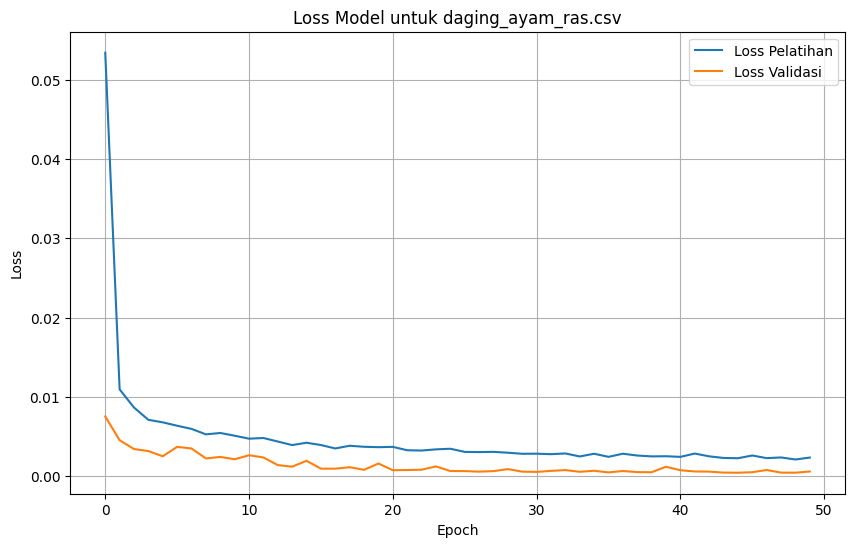


Melatih model untuk daging_sapi.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0429 - val_loss: 5.2914e-04
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0068 - val_loss: 6.4172e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0057 - val_loss: 6.9698e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0055 - val_loss: 8.9434e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050 - val_loss: 6.1165e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 7.1881e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 7.0592e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0046 - val_loss: 9.0687e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0041 - val_loss: 0

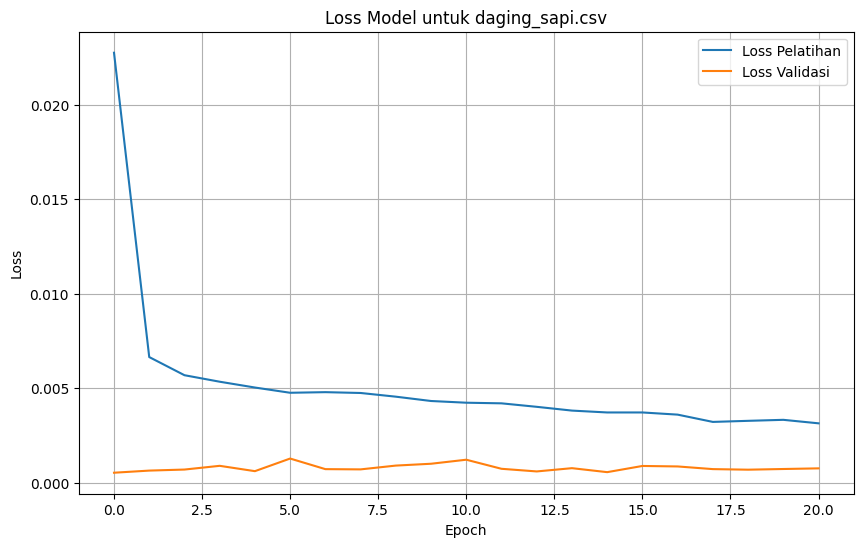


Melatih model untuk gula_pasir.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0214 - val_loss: 0.0073
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0014 - val_loss: 0.0058
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0015 - val_loss: 0.0096
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0053
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0013 - val_loss: 0.0113
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 12/50
29/29 ━━━━━━━━━

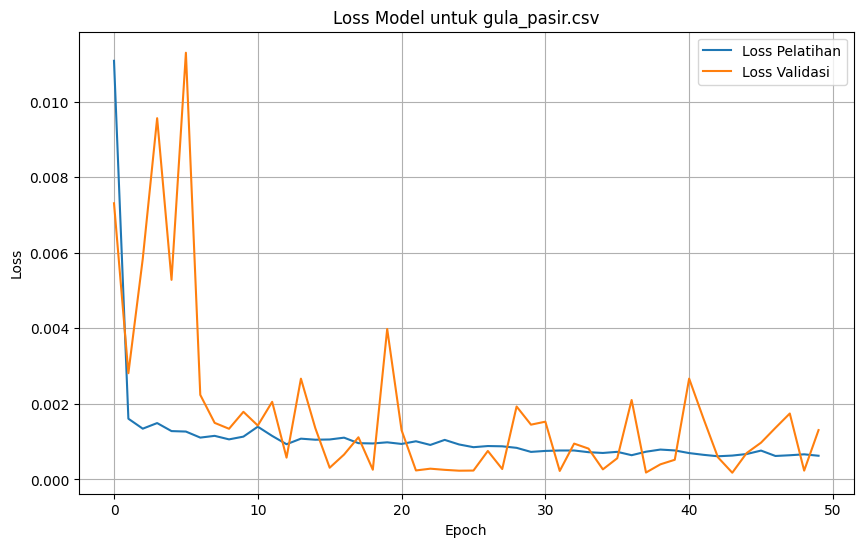


Melatih model untuk kedelai.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0891 - val_loss: 0.0030
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0094 - val_loss: 8.5646e-04
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0063 - val_loss: 3.0556e-04
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0054 - val_loss: 3.7173e-04
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054 - val_loss: 3.4092e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049 - val_loss: 3.7453e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0045 - val_loss: 3.1195e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0046 - val_loss: 2.7676e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - val_loss: 7.6636e-04
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0042 - val_loss: 2.7868e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0046 - val_loss: 3

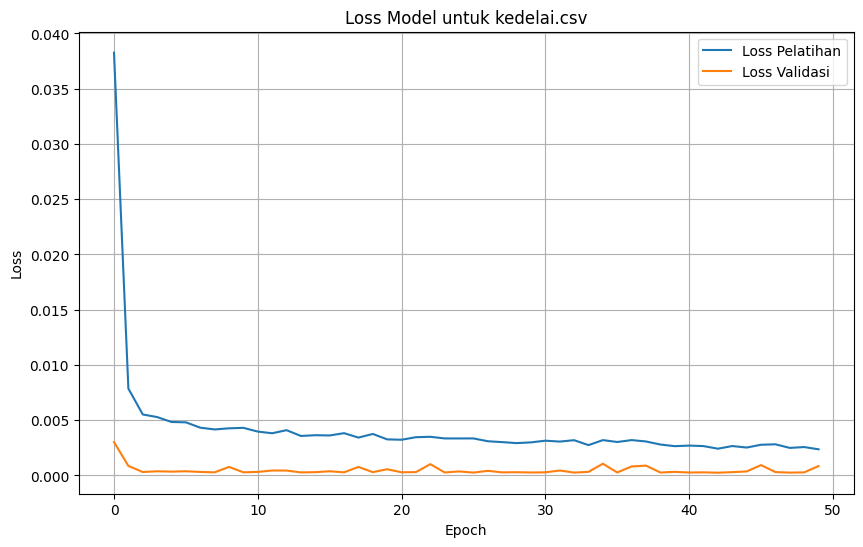


Melatih model untuk telur_ayam_ras.csv
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.1066 - val_loss: 0.0038
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0121 - val_loss: 0.0044
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0086 - val_loss: 0.0019
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0077 - val_loss: 0.0012
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0062 - val_loss: 7.1661e-04
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0059 - val_loss: 7.2117e-04
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0064 - val_loss: 0.0018
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0049 - val_loss: 6.5090e-04
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0047 - val_loss: 6.3920e-04
Epoch 1

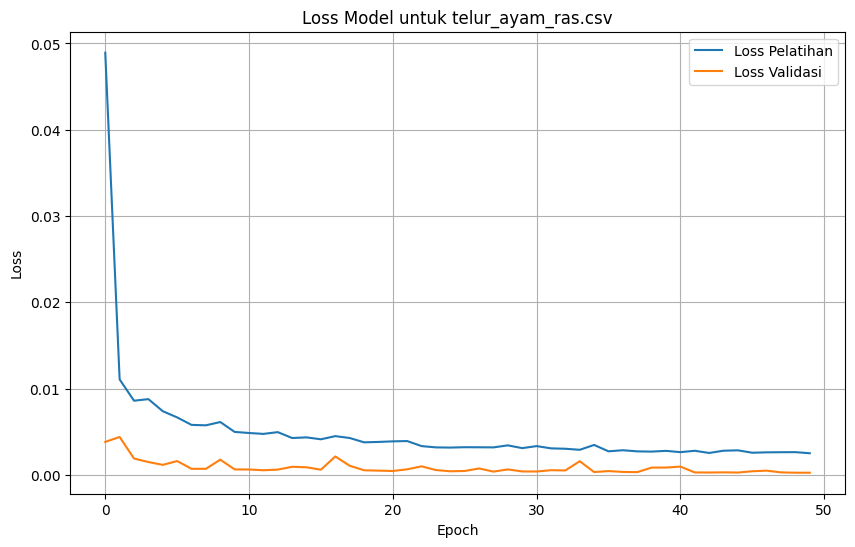

In [16]:
# Melatih model untuk setiap dataset
model_results = {}
for file, (X_train, X_test, y_train, y_test) in split_datasets.items():
    print(f"\nMelatih model untuk {file}")
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    model = build_model((X_train.shape[1], 1))

    # Penghentian dini untuk mencegah overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Menyimpan model
    model.save(f"C:/D/projects/BPP PROJECT/bpp-prediction/backend/models_50/{file}_model.h5")
    model_results[file] = model
    
    #  # Menampilkan Hidden State dan Cell State pada timestep terakhir
    # print("\nEvaluasi pada data uji (X_test):")
    # output, state_h, state_c = model.predict(X_test)
    # print("Hidden State terakhir (state_h):", state_h)
    # print("Cell State terakhir (state_c):", state_c)
    
    # Plot riwayat pelatihan
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Loss Pelatihan')
    plt.plot(history.history['val_loss'], label='Loss Validasi')
    plt.title(f'Loss Model untuk {file}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
# Fungsi untuk evaluasi
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return rmse, mae

def denormalize_data(scaled_data, dataset_name):
    return scalers[dataset_name].inverse_transform(scaled_data)


In [18]:
# Evaluasi model dan membuat prediksi
evaluations = {}
predictions = {}

for file, model in model_results.items():
    X_test = split_datasets[file][1].reshape(-1, 60, 1)
    y_test = split_datasets[file][3]
    
    # Membuat prediksi
    y_pred_scaled = model.predict(X_test)
    
    # Denormalisasi
    y_pred_rescaled = denormalize_data(y_pred_scaled, file)
    y_test_rescaled = denormalize_data(y_test.reshape(-1, 1), file)
    
    # Menghitung metrik
    rmse, mae = evaluate_model(model, X_test, y_test)
    evaluations[file] = {'RMSE': rmse, 'MAE': mae}
    
    predictions[file] = {
        'y_pred': y_pred_rescaled,
        'y_test': y_test_rescaled
    }


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [19]:
# Fungsi untuk memplot prediksi
def plot_predictions(file, predictions, evaluations):
    y_pred = predictions[file]['y_pred']
    y_test = predictions[file]['y_test']
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label='Harga Aktual', linewidth=2)
    plt.plot(y_pred, label='Harga Prediksi', linewidth=2)
    plt.title(f'Prediksi Harga BPP untuk {file}\nRMSE: {evaluations[file]["RMSE"]:.2f}, MAE: {evaluations[file]["MAE"]:.2f}')
    plt.xlabel('Waktu')
    plt.ylabel('Harga (Rupiah)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

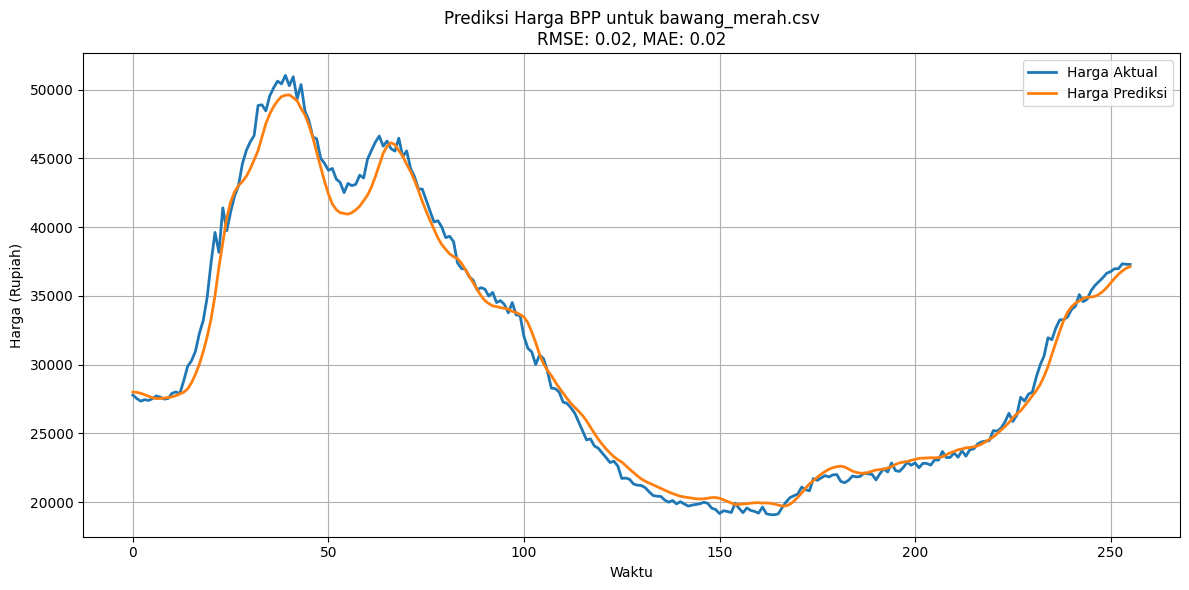

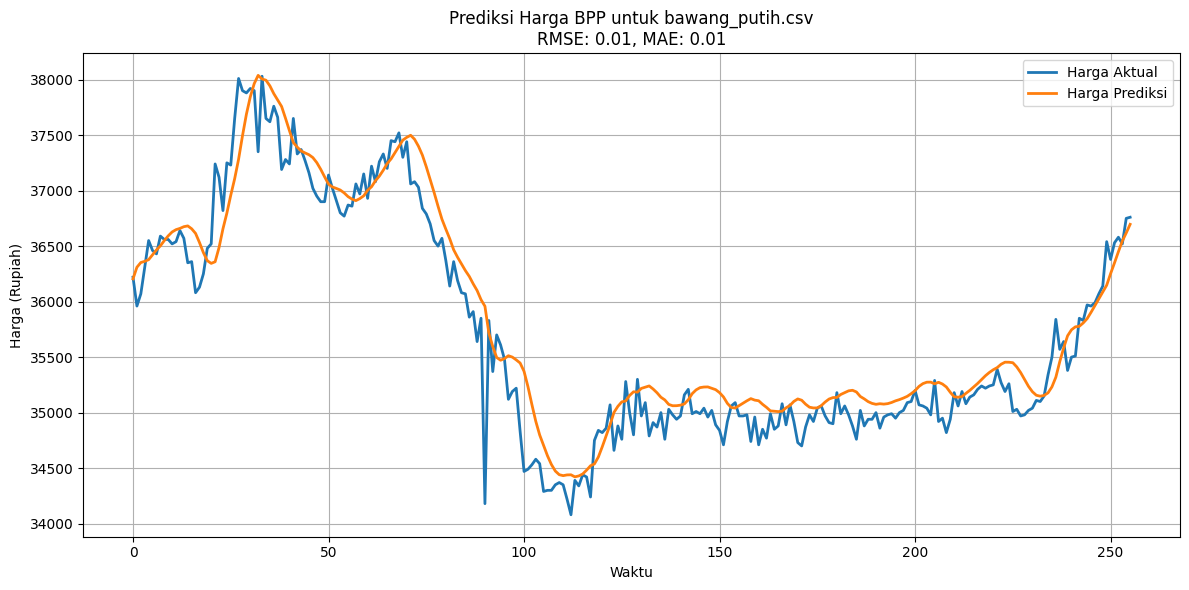

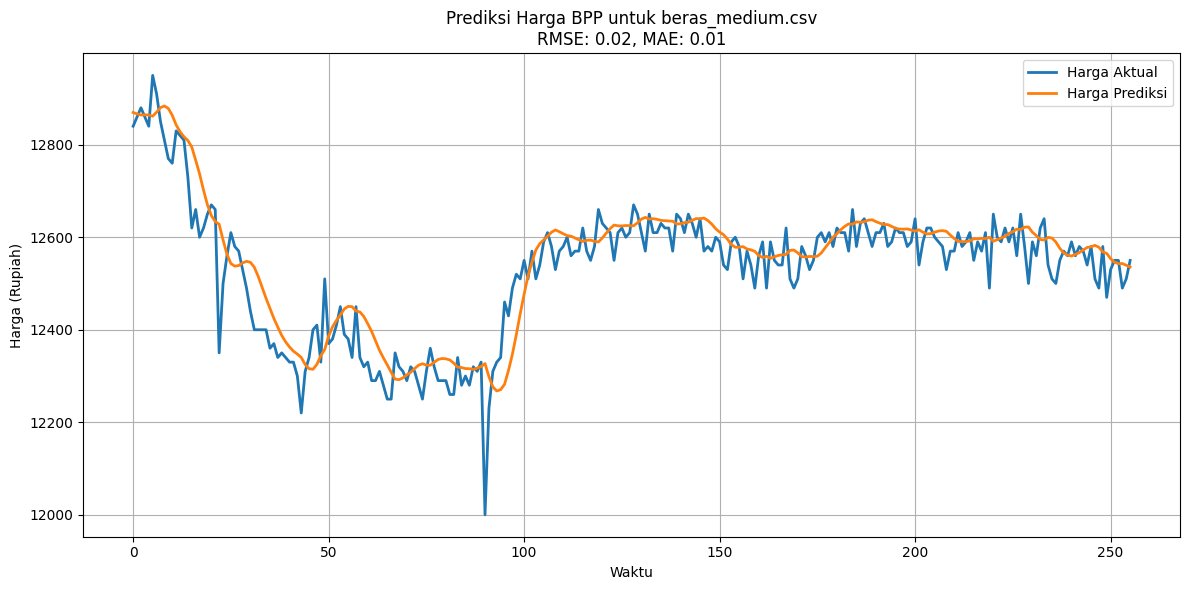

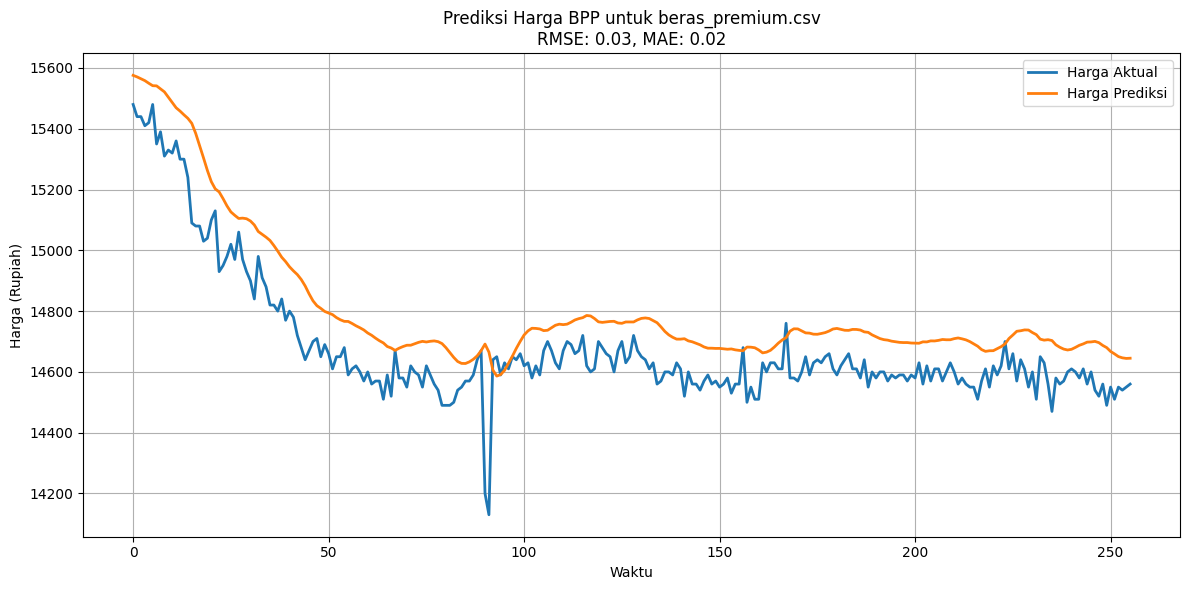

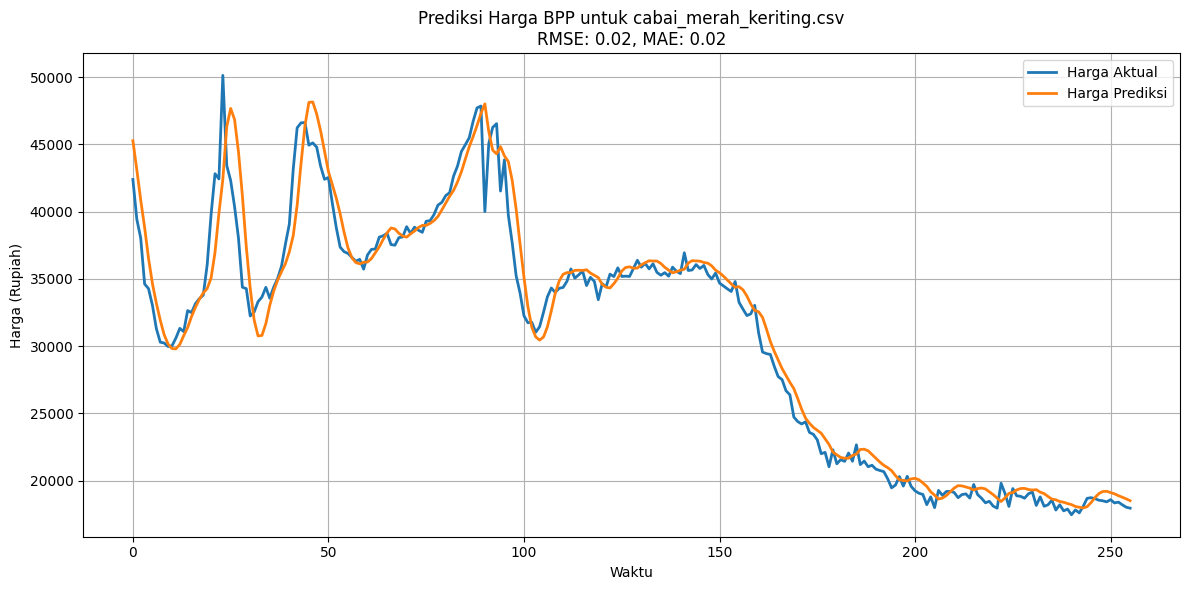

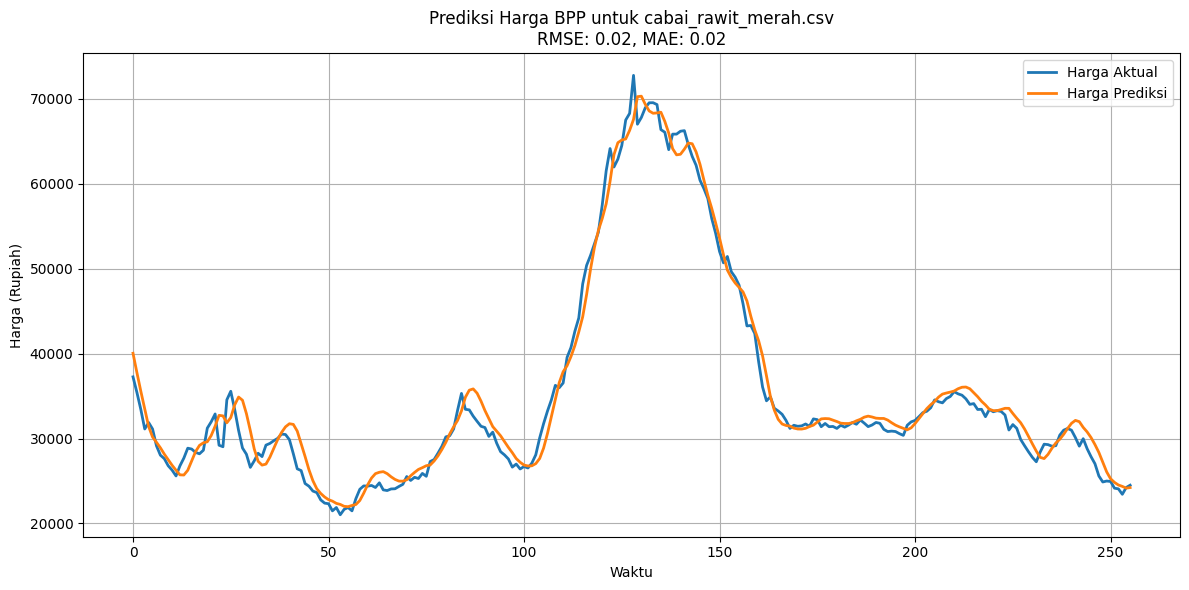

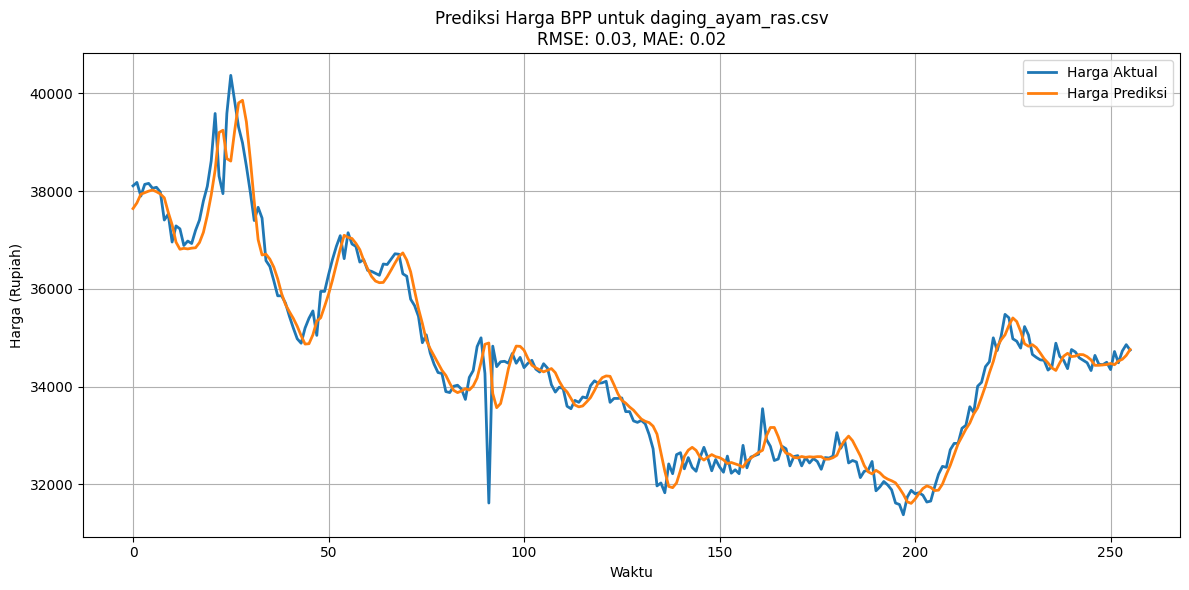

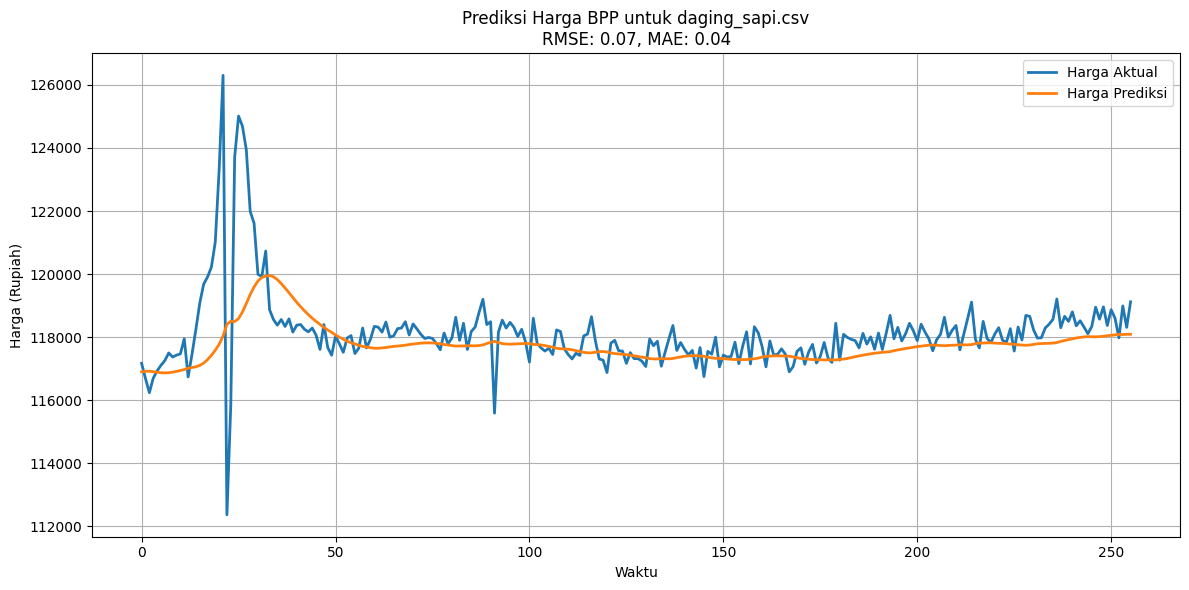

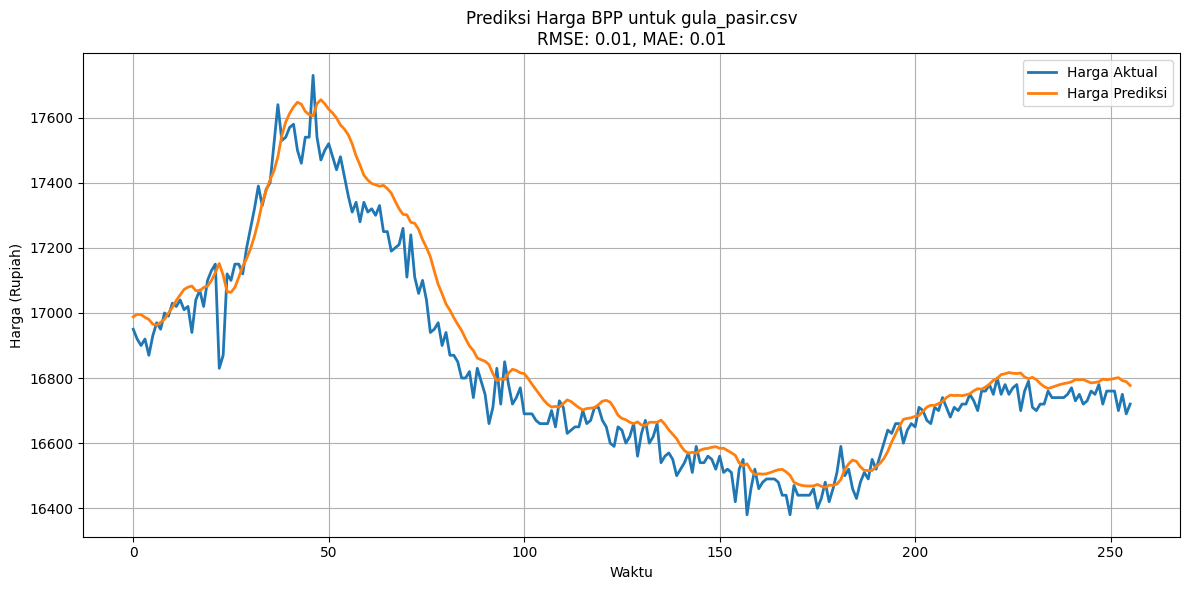

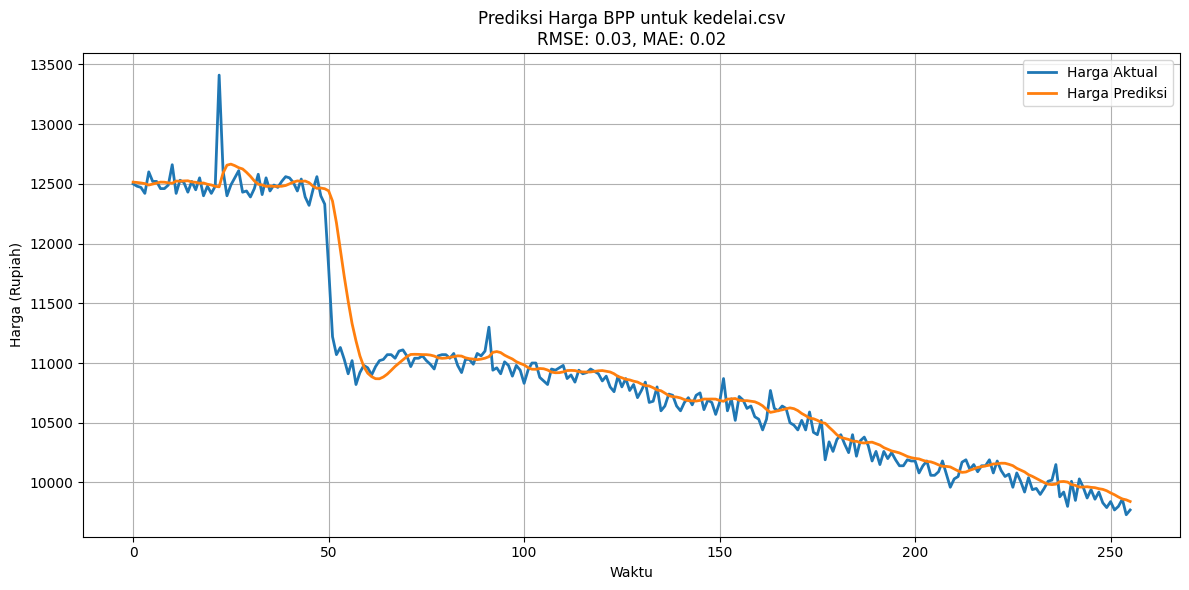

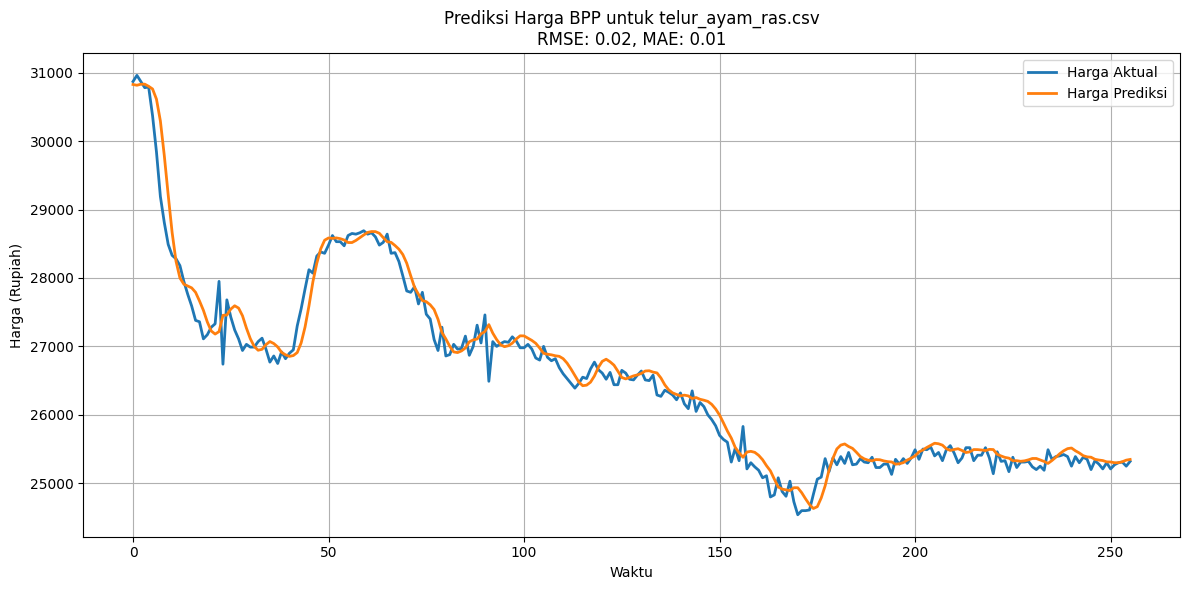


Hasil Evaluasi Akhir:

Metrik untuk bawang_merah.csv:
RMSE: 0.0216
MAE: 0.0157

Metrik untuk bawang_putih.csv:
RMSE: 0.0143
MAE: 0.0107

Metrik untuk beras_medium.csv:
RMSE: 0.0151
MAE: 0.0108

Metrik untuk beras_premium.csv:
RMSE: 0.0257
MAE: 0.0230

Metrik untuk cabai_merah_keriting.csv:
RMSE: 0.0248
MAE: 0.0161

Metrik untuk cabai_rawit_merah.csv:
RMSE: 0.0204
MAE: 0.0159

Metrik untuk daging_ayam_ras.csv:
RMSE: 0.0288
MAE: 0.0194

Metrik untuk daging_sapi.csv:
RMSE: 0.0716
MAE: 0.0387

Metrik untuk gula_pasir.csv:
RMSE: 0.0143
MAE: 0.0112

Metrik untuk kedelai.csv:
RMSE: 0.0335
MAE: 0.0188

Metrik untuk telur_ayam_ras.csv:
RMSE: 0.0173
MAE: 0.0122


In [20]:
# Plot hasil untuk setiap dataset
for file in predictions.keys():
    plot_predictions(file, predictions, evaluations)

# Menampilkan hasil evaluasi akhir
print("\nHasil Evaluasi Akhir:")
for name, metrics in evaluations.items():
    print(f"\nMetrik untuk {name}:")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

In [21]:

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)